## Customer Segmentation:

### 1. Import Packages and Data:

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
#matplotlib.style.use('ggplot')

# remove warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

%matplotlib inline
#this is a cool trick to have better looking plots:
%config InlineBackend.figure_format = 'retina'



### Wholesale customers Data Set:

**The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units on diverse product categories.**

In [3]:
#from here: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers
#import data 
#Read in data from source 
df = pd.read_csv("Wholesale customers data.csv")
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

In [5]:
# sanity check - size of dataset
df.shape

(440, 8)

**Attribute Information**:

1)	FRESH: annual spending on fresh products (Continuous)

2)	MILK: annual spending on milk products (Continuous)

3)	GROCERY: annual spending on grocery products (Continuous)

4)	FROZEN: annual spending on frozen products (Continuous) 

5)	DETERGENTS_PAPER: annual spending on detergents and paper products (Continuous) 

6)	DELICATESSEN: annual spending on and delicatessen products (Continuous)

7)	CHANNEL: customers Channel - Horeca (Hotel/Restaurant) or Retail channel (Nominal) 

8)	REGION: customers Region Lisabon, Porto or Other (Nominal) 


REGION	Frequency 
Lisbon	77 
Oporto	47 
Other Region	316 
Total	440 

CHANNEL	Frequency 
Horeca	298 
Retail	142 
Total	440 



In [6]:
#name the categorical variables:
df["region_name"] = df["Region"].map({1:"Lisabon", 2:"Porto", 3:"Other"})
df["channel_name"] = df["Channel"].map({1:"Hotel/Restaurant", 2:"Retail"})

### 2. Define Problem:

**- Visualize the data and identify correlations between sales.**

**- Segment and cluster the wholesale customers in terms of annual sales to identify patterns.**

In [7]:
#eliminating some outliers for better visualization:
num_df = df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]
good_index = num_df[(np.abs(stats.zscore(num_df)) < 2.5).all(axis=1)].index
df = df.loc[good_index]

### 3. Visualize:

#### Scatterplots:

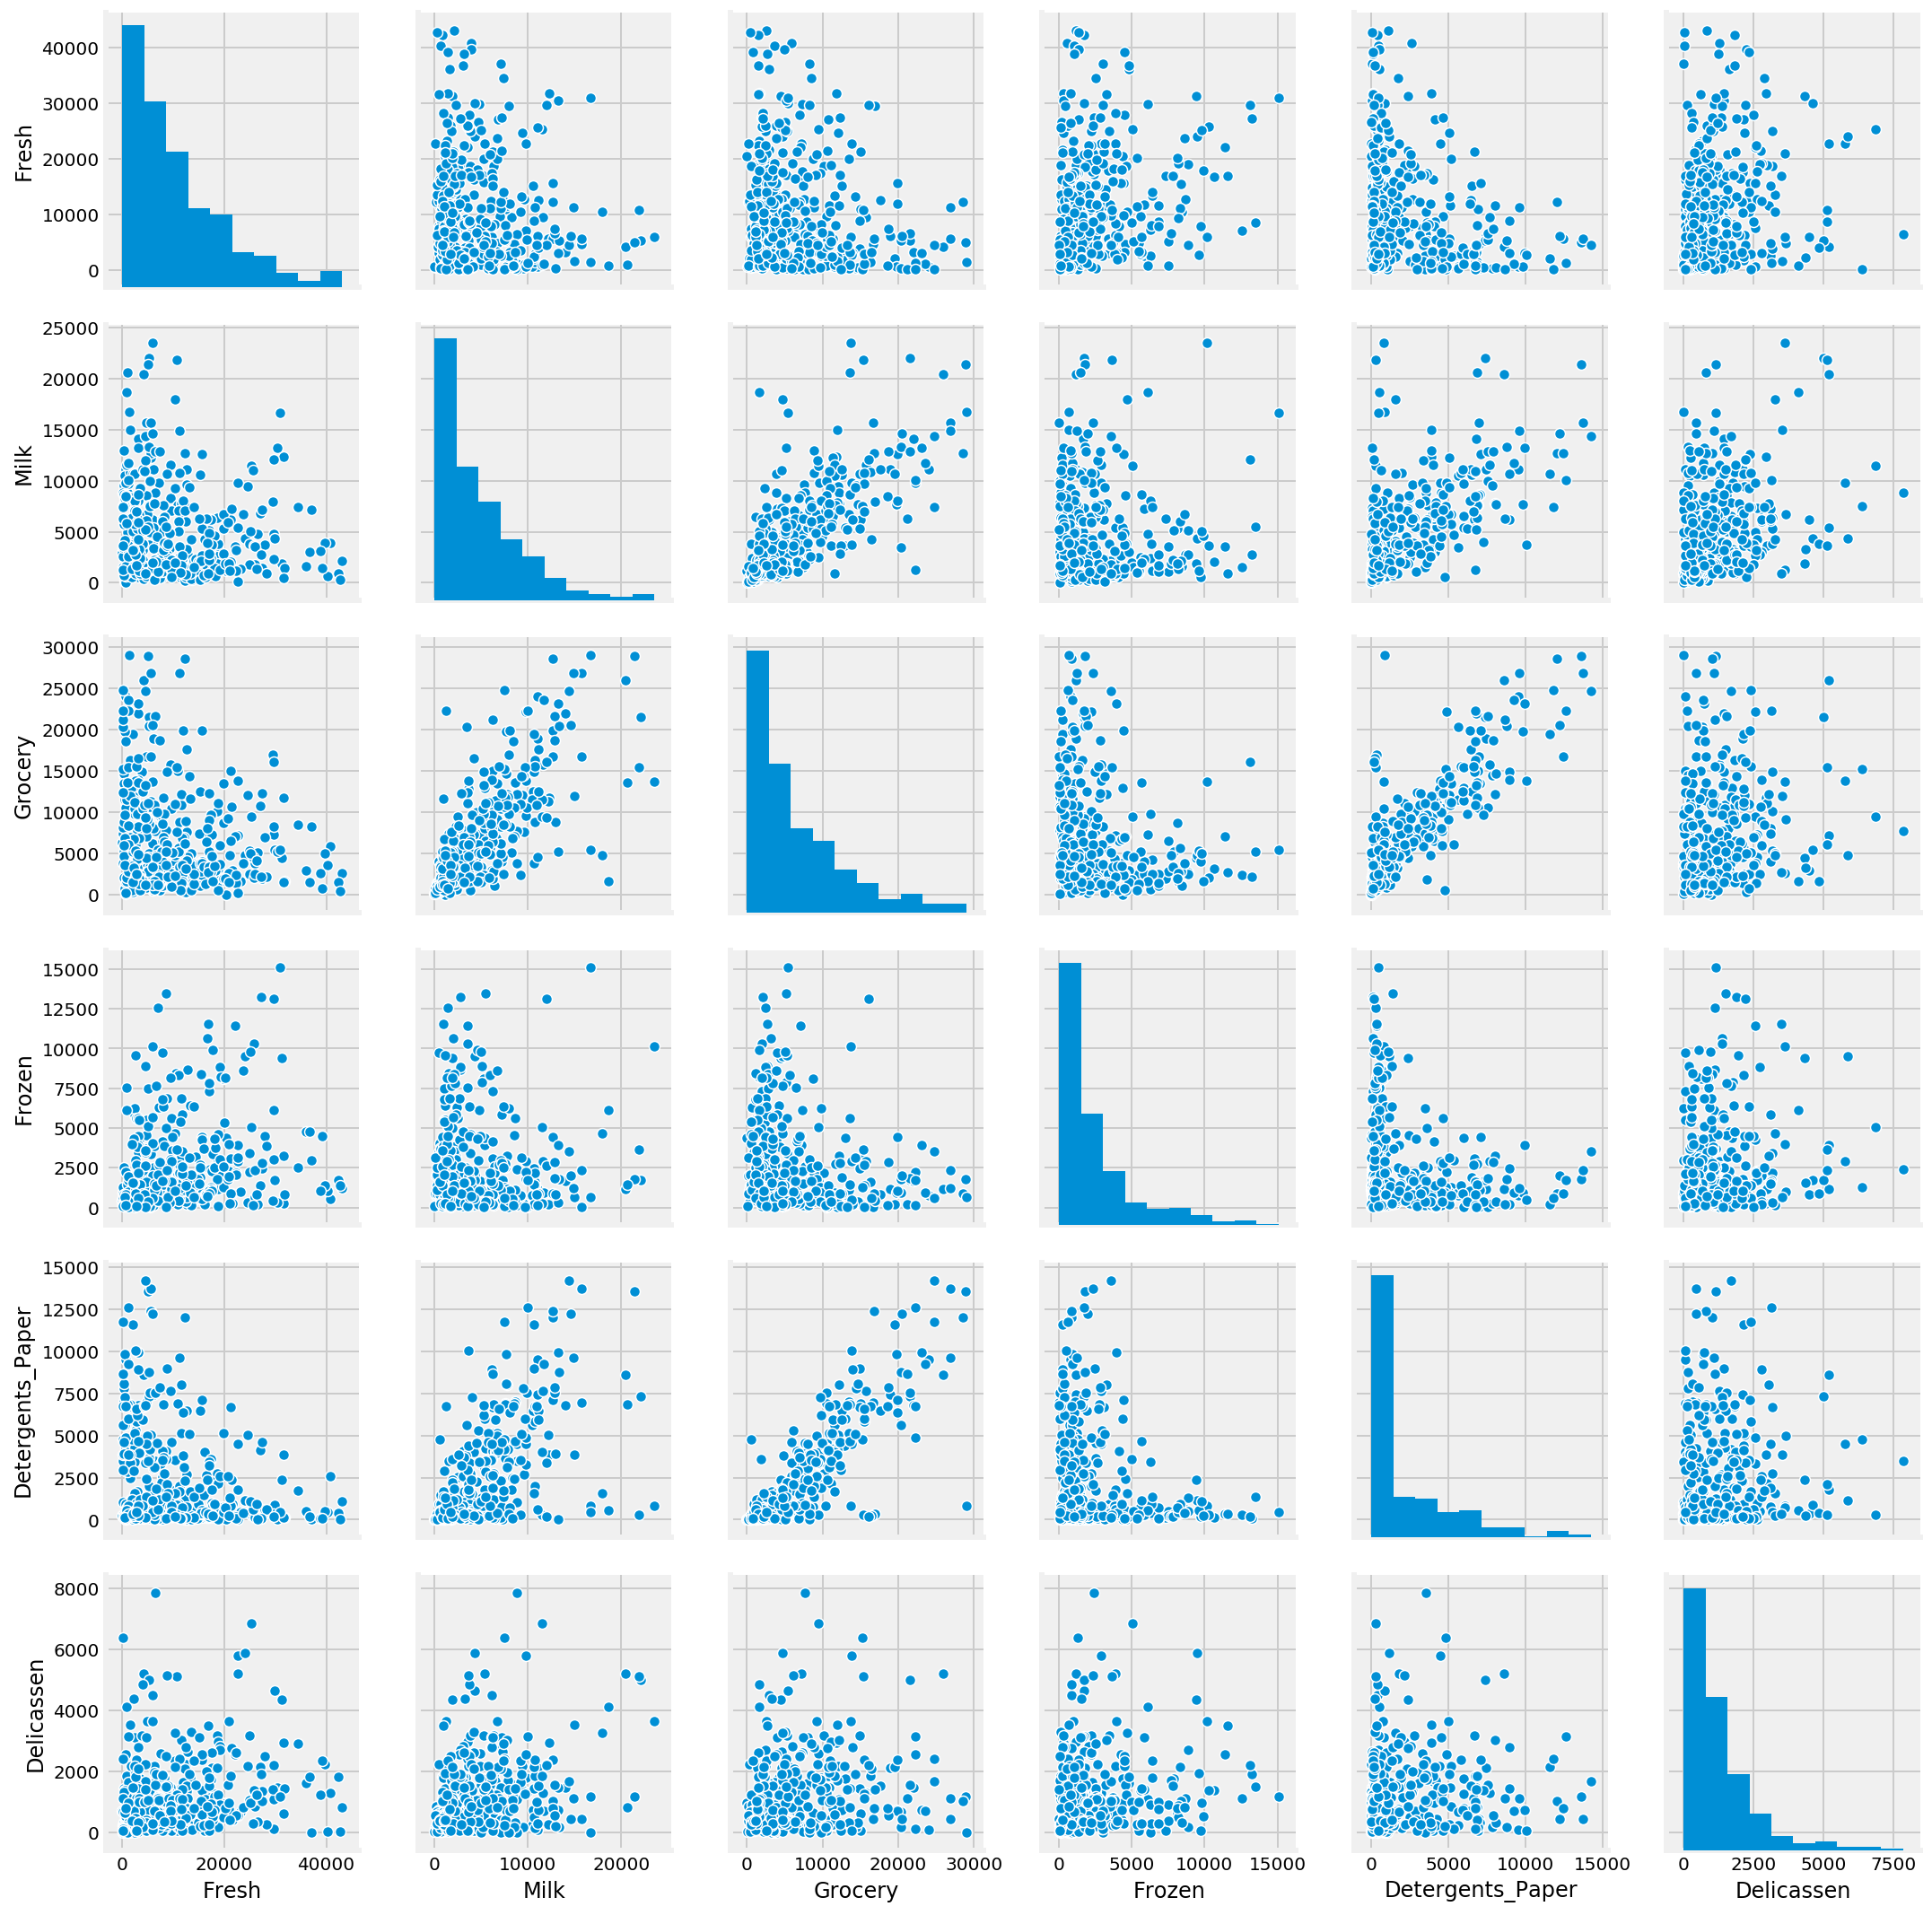

In [8]:
sns.pairplot(df.loc[:,"Fresh":"Delicassen"])

#### Looking at Correlations:

In [9]:
correlations = df.loc[:,"Fresh":"Delicassen"].corr()

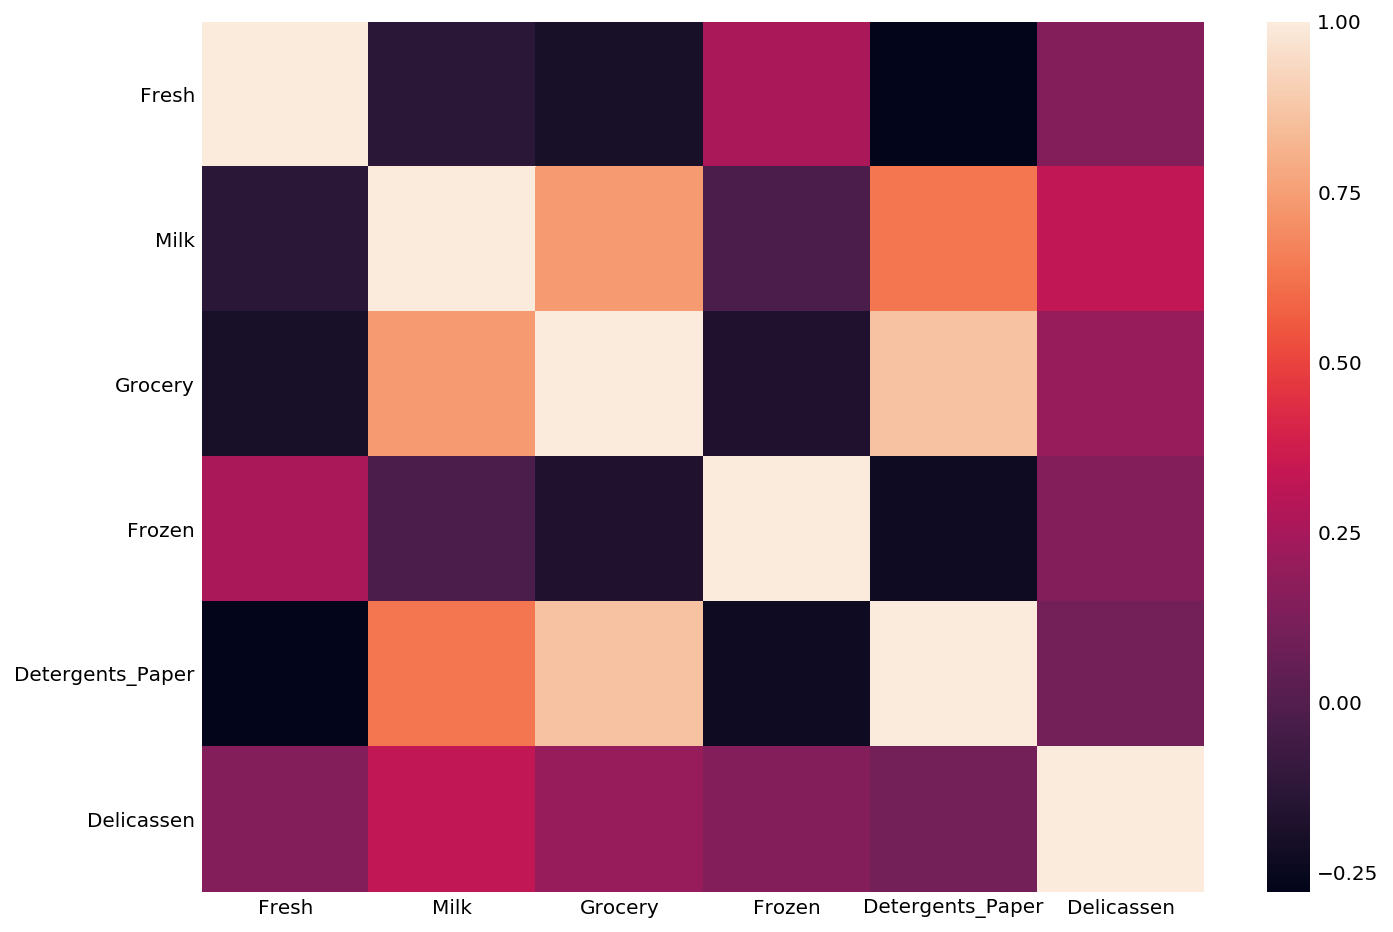

In [10]:
plt.figure(figsize = (10, 8))
sns.heatmap(correlations)

### Based on the scatterplots and the correlation heatmap we observe the following:


- **Milk and Gorcery Sales are positively correlated - meaning clients who buy a lot of one buy a lot of the other**
- **Grocery and Detergents/Paper are positively correlated as well**

### Slicing based on Channel Name:

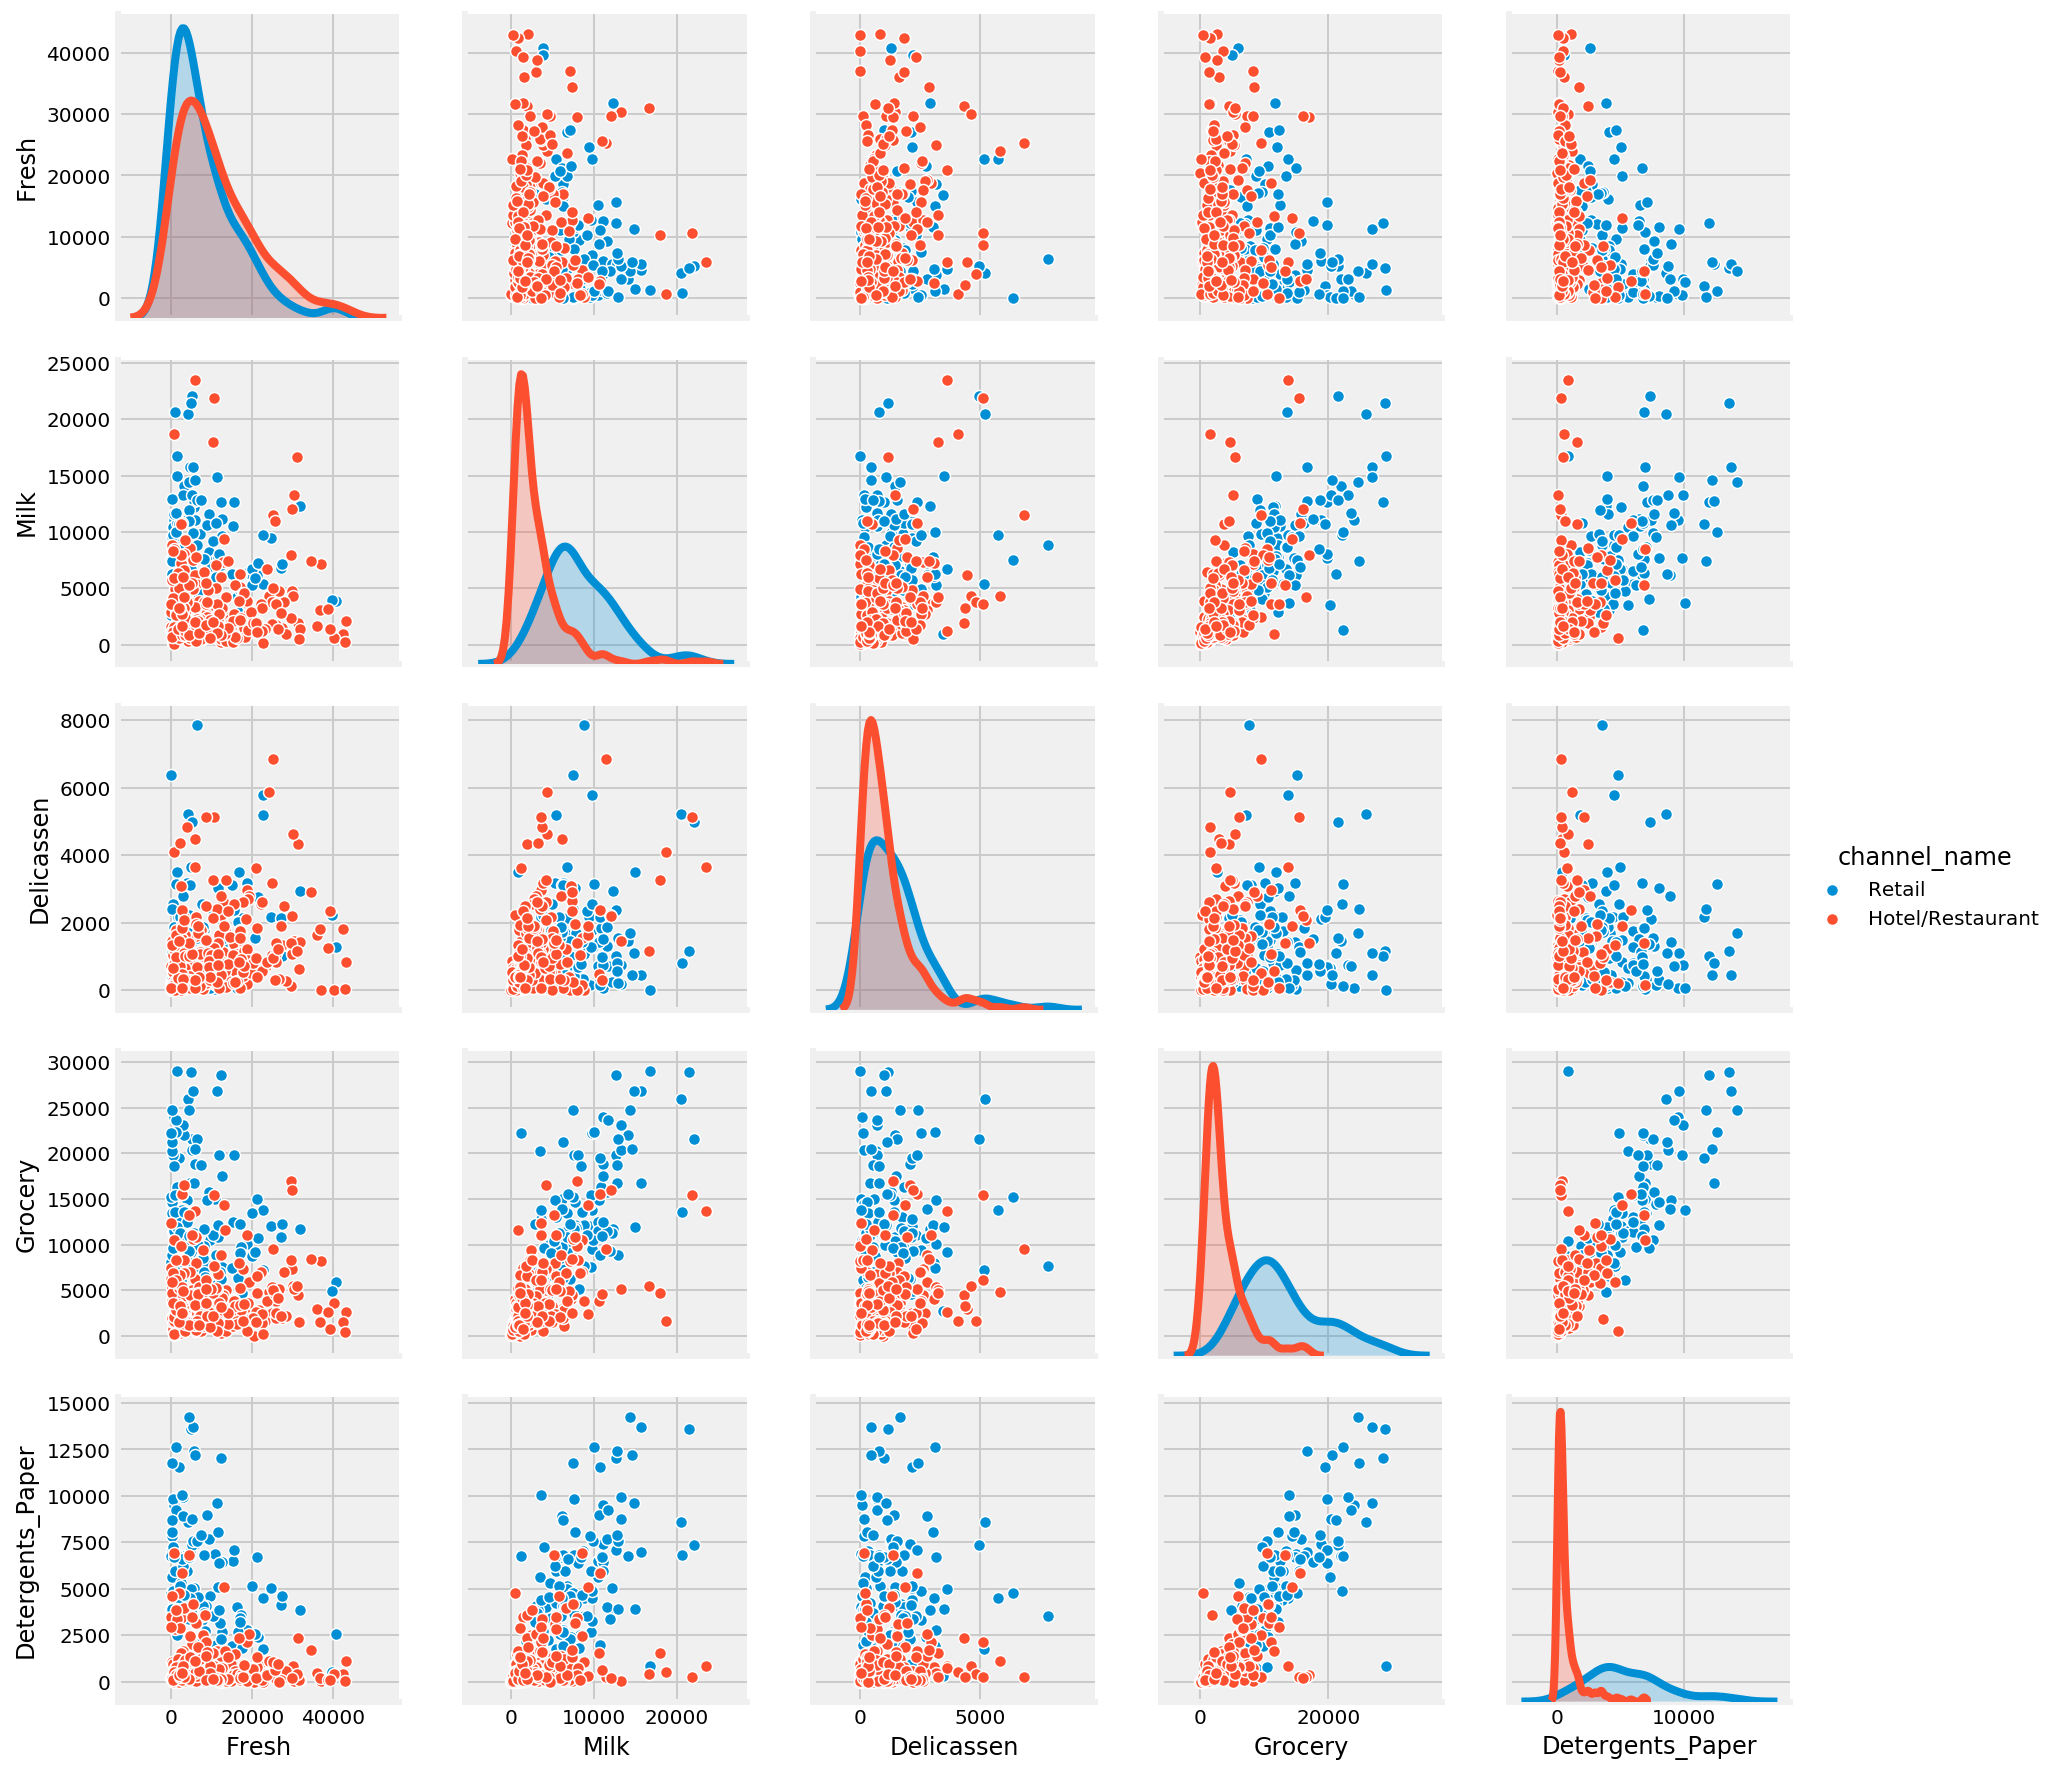

In [11]:
sns.pairplot(df[["Fresh", "Milk", "Delicassen", "Grocery", "channel_name", "Detergents_Paper"]], hue = "channel_name")

In [12]:
df.groupby("channel_name").mean()

Channel    Region         Fresh         Milk       Grocery  \
channel_name                                                                   
Hotel/Restaurant      1.0  2.510791  11497.500000  3159.276978   3676.902878   
Retail                2.0  2.629032   8270.201613  8355.887097  13112.798387   

                       Frozen  Detergents_Paper   Delicassen  
channel_name                                                  
Hotel/Restaurant  2843.226619        764.629496  1092.381295  
Retail            1562.935484       5521.540323  1516.225806

Text(0.5, 1.0, 'Gorcery Sales vs. Channel')

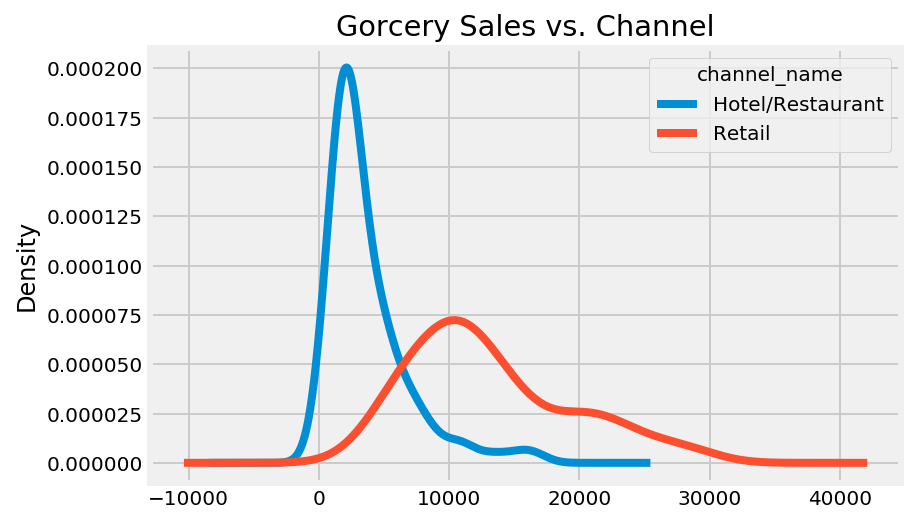

In [13]:
df[["Grocery", "channel_name"]].pivot(columns = "channel_name", values = "Grocery").plot.density()
plt.title("Gorcery Sales vs. Channel")

### From the table and the visalization above we can observe the following:

- **Gorcery, Milk, and Detergents_Paper	have higher sales for the Retail channel name over the Hotel/Restaurant channel.**
- **For Fresh Produce and Delicassen the differences aren't very significant between the Hotel/Restaurant and Retail channels**

### 4. Customer Segmentation:

We will use the KMeans algorithm to cluster the customers based on how much they buy in the different categories:

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

In [15]:
X = df.loc[:,"Fresh":"Delicassen"]

In [16]:
X.head()

Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185

In [17]:
#here use a scaling of the data first 
#this is so that KMeans treats all the 
#categories as equal:

kmeans = make_pipeline(MinMaxScaler(),
                       KMeans(n_clusters=4, random_state = 4))

In [18]:
kmeans.fit(X)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=4, tol=0.0001, verbose=0))])

In [19]:
#add the clusters to the dataframe for easier visualization:
X["clusters"] = kmeans.named_steps["kmeans"].labels_

### Visualizing the Clusters:

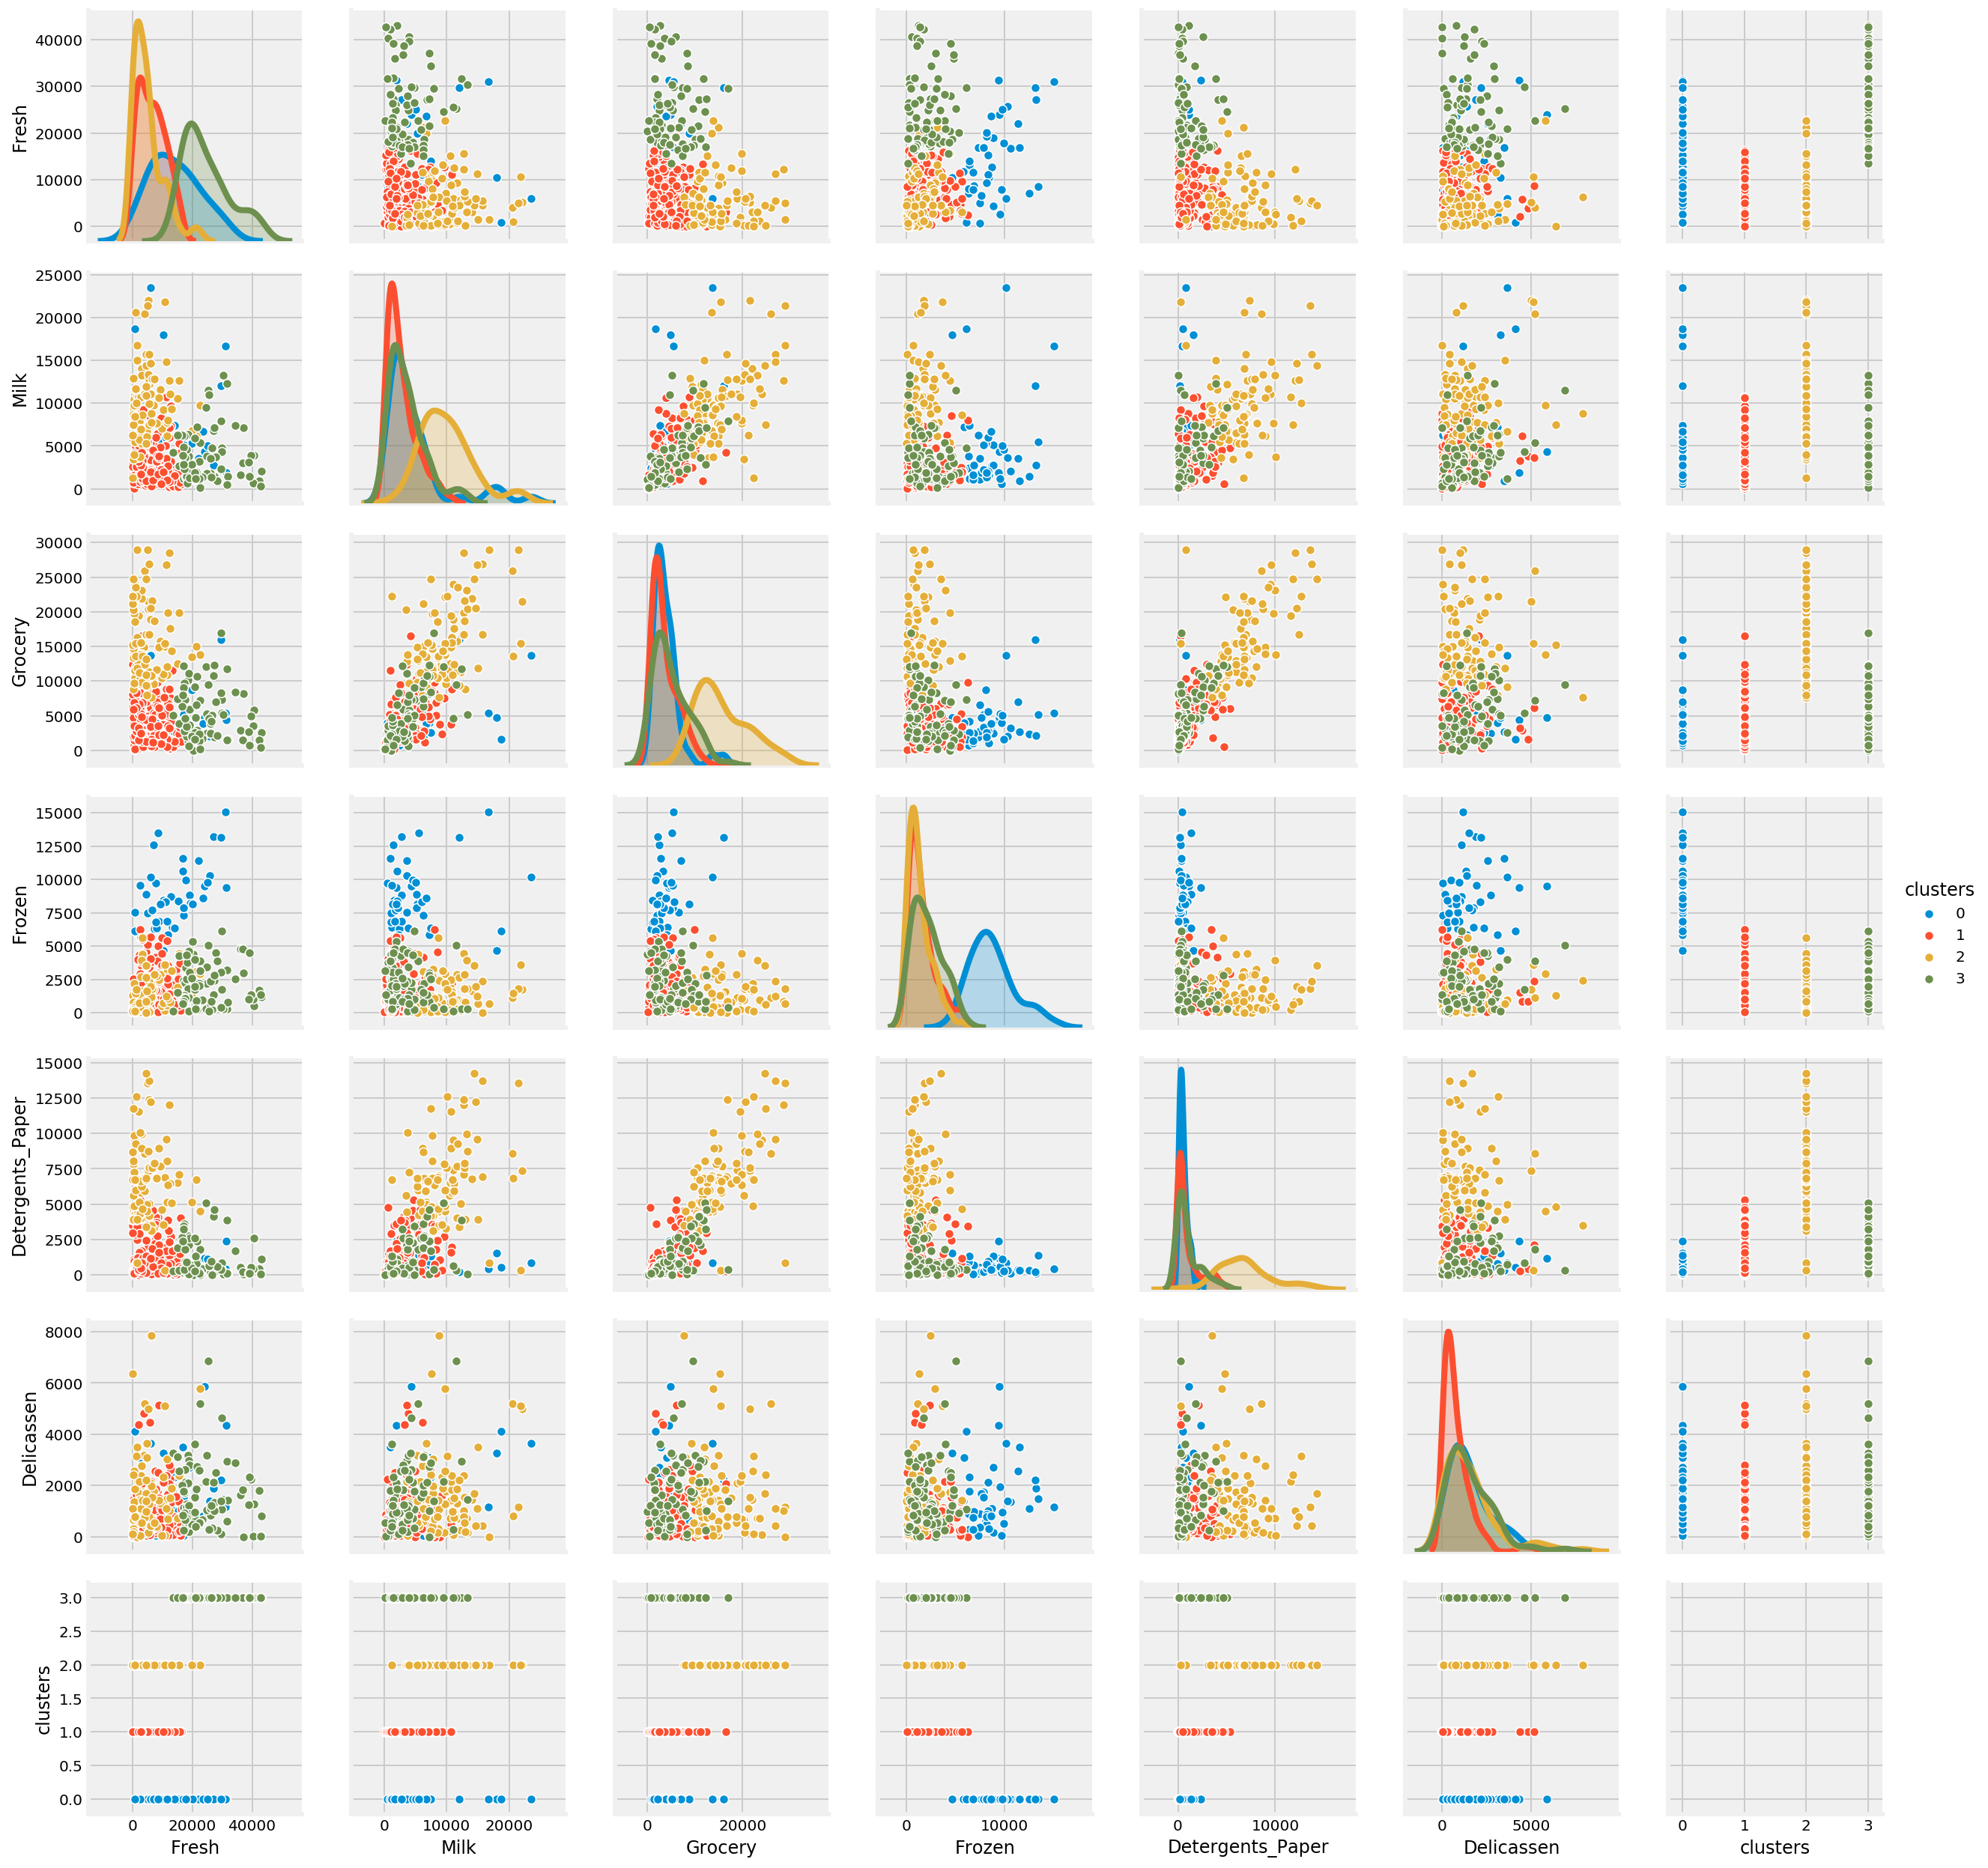

In [20]:
sns.pairplot(X, hue = "clusters")

We can get some intuition on the clusters even just by looking at the scatterplots. Let's look at the one more closely:

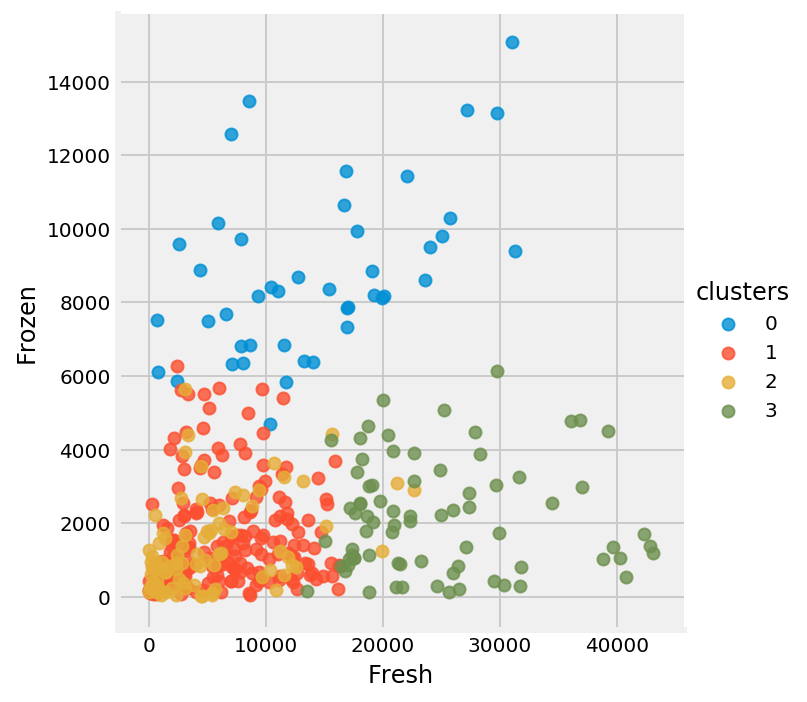

In [21]:
sns.lmplot(x = "Fresh", y = "Frozen", data = X, hue = "clusters", fit_reg = False)

We observe the following based on the scatterplot above:

- ** Cluster 1 and 2 are mostly clients who buy less Fresh and Frozen products**

- ** Clients in Cluster 3 buy a lot of Frozen products but not a lot of Fresh Products**

- ** Clients in Cluster 0 clients buy a lot of Fresh but not a lot of Frozen Products**

### Interpreting the Segments:

Let's look at the center of each cluster and see what the coefficients are - the largest coefficients will be the dominant features for that specific cluster so we can get an intuition of what dimensions are important for each cluster:

In [22]:
centers = kmeans.named_steps["kmeans"].cluster_centers_

In [23]:
centers = pd.DataFrame(centers, columns = X.columns[:6])

Text(0.5, 1.0, 'Cluster 0 Center Coordinates')

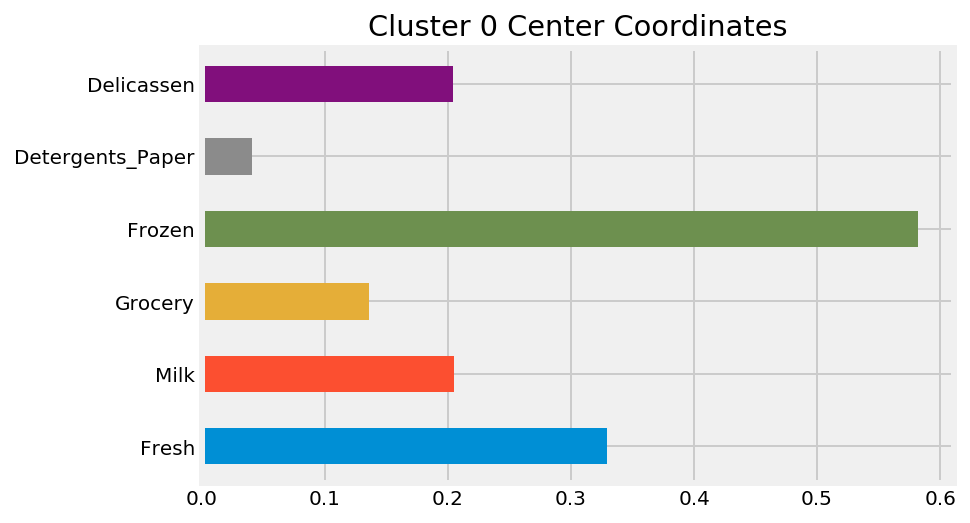

In [24]:
centers.iloc[0].plot(kind = "barh")
plt.title("Cluster 0 Center Coordinates")

Text(0.5, 1.0, 'Cluster 1 Center Coordinates')

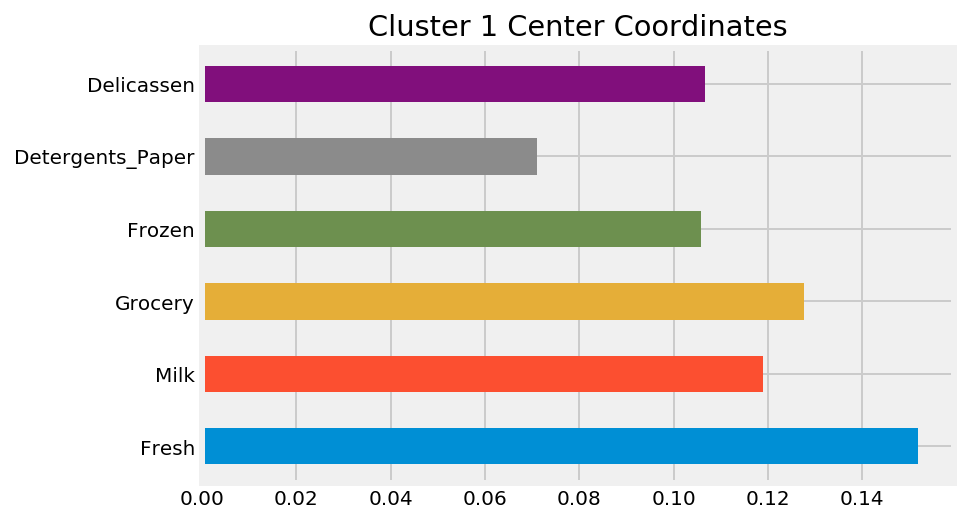

In [25]:
centers.iloc[1].plot(kind = "barh")
plt.title("Cluster 1 Center Coordinates")

Text(0.5, 1.0, 'Cluster 2 Center Coordinates')

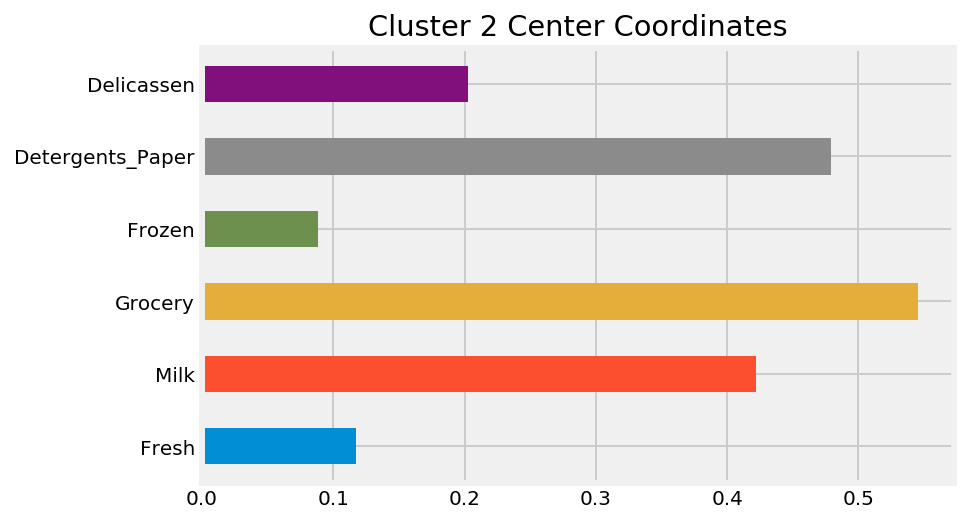

In [26]:
centers.iloc[2].plot(kind = "barh")
plt.title("Cluster 2 Center Coordinates")

Text(0.5, 1.0, 'Cluster 3 Center Coordinates')

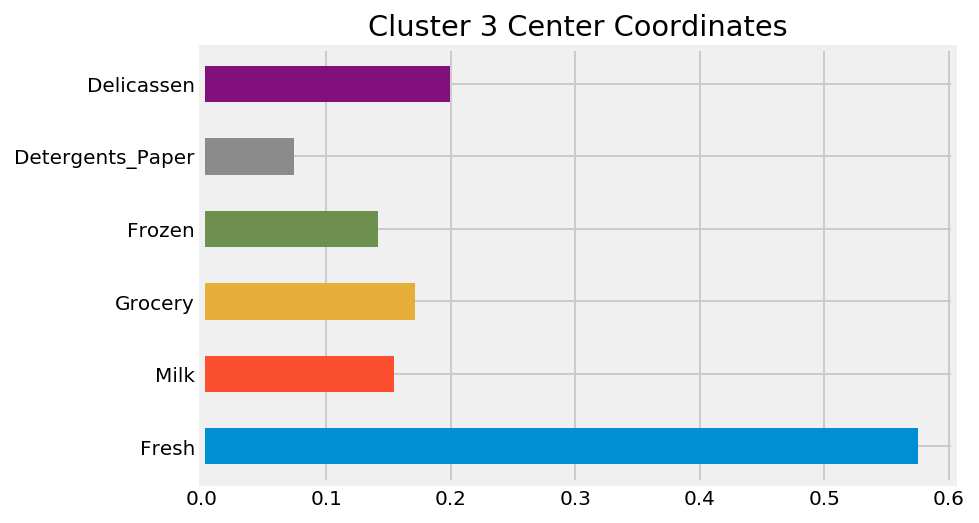

In [27]:
centers.iloc[3].plot(kind = "barh")
plt.title("Cluster 3 Center Coordinates")

Based on the size of the bars in the barplots above we can get an idea of the different important features in each cluster:

- **Cluster 0: Clients who spend a lot in the Frozen Categories**
- **Cluster 1: A balanced cluster - clients with roughly similar buying habits across the categories - leaning toward the Grovery/Milk/Fresh categories however**
- **Cluster 2: Clients who spend a lot in the Grocery + Detergents + Milk Categories and less in all the other categories**
- **Clsuter 3: Clients who spend a lot in the Fresh Category and less of everything else**

### We can also play around with the number of clusters - let's try only 2:

In [28]:
X = df.loc[:,"Fresh":"Delicassen"]
kmeans = make_pipeline(MinMaxScaler(),
                       KMeans(n_clusters=2, random_state = 4))
kmeans.fit(X)
#add the clusters to the dataframe for easier visualization:
X["clusters"] = kmeans.named_steps["kmeans"].labels_


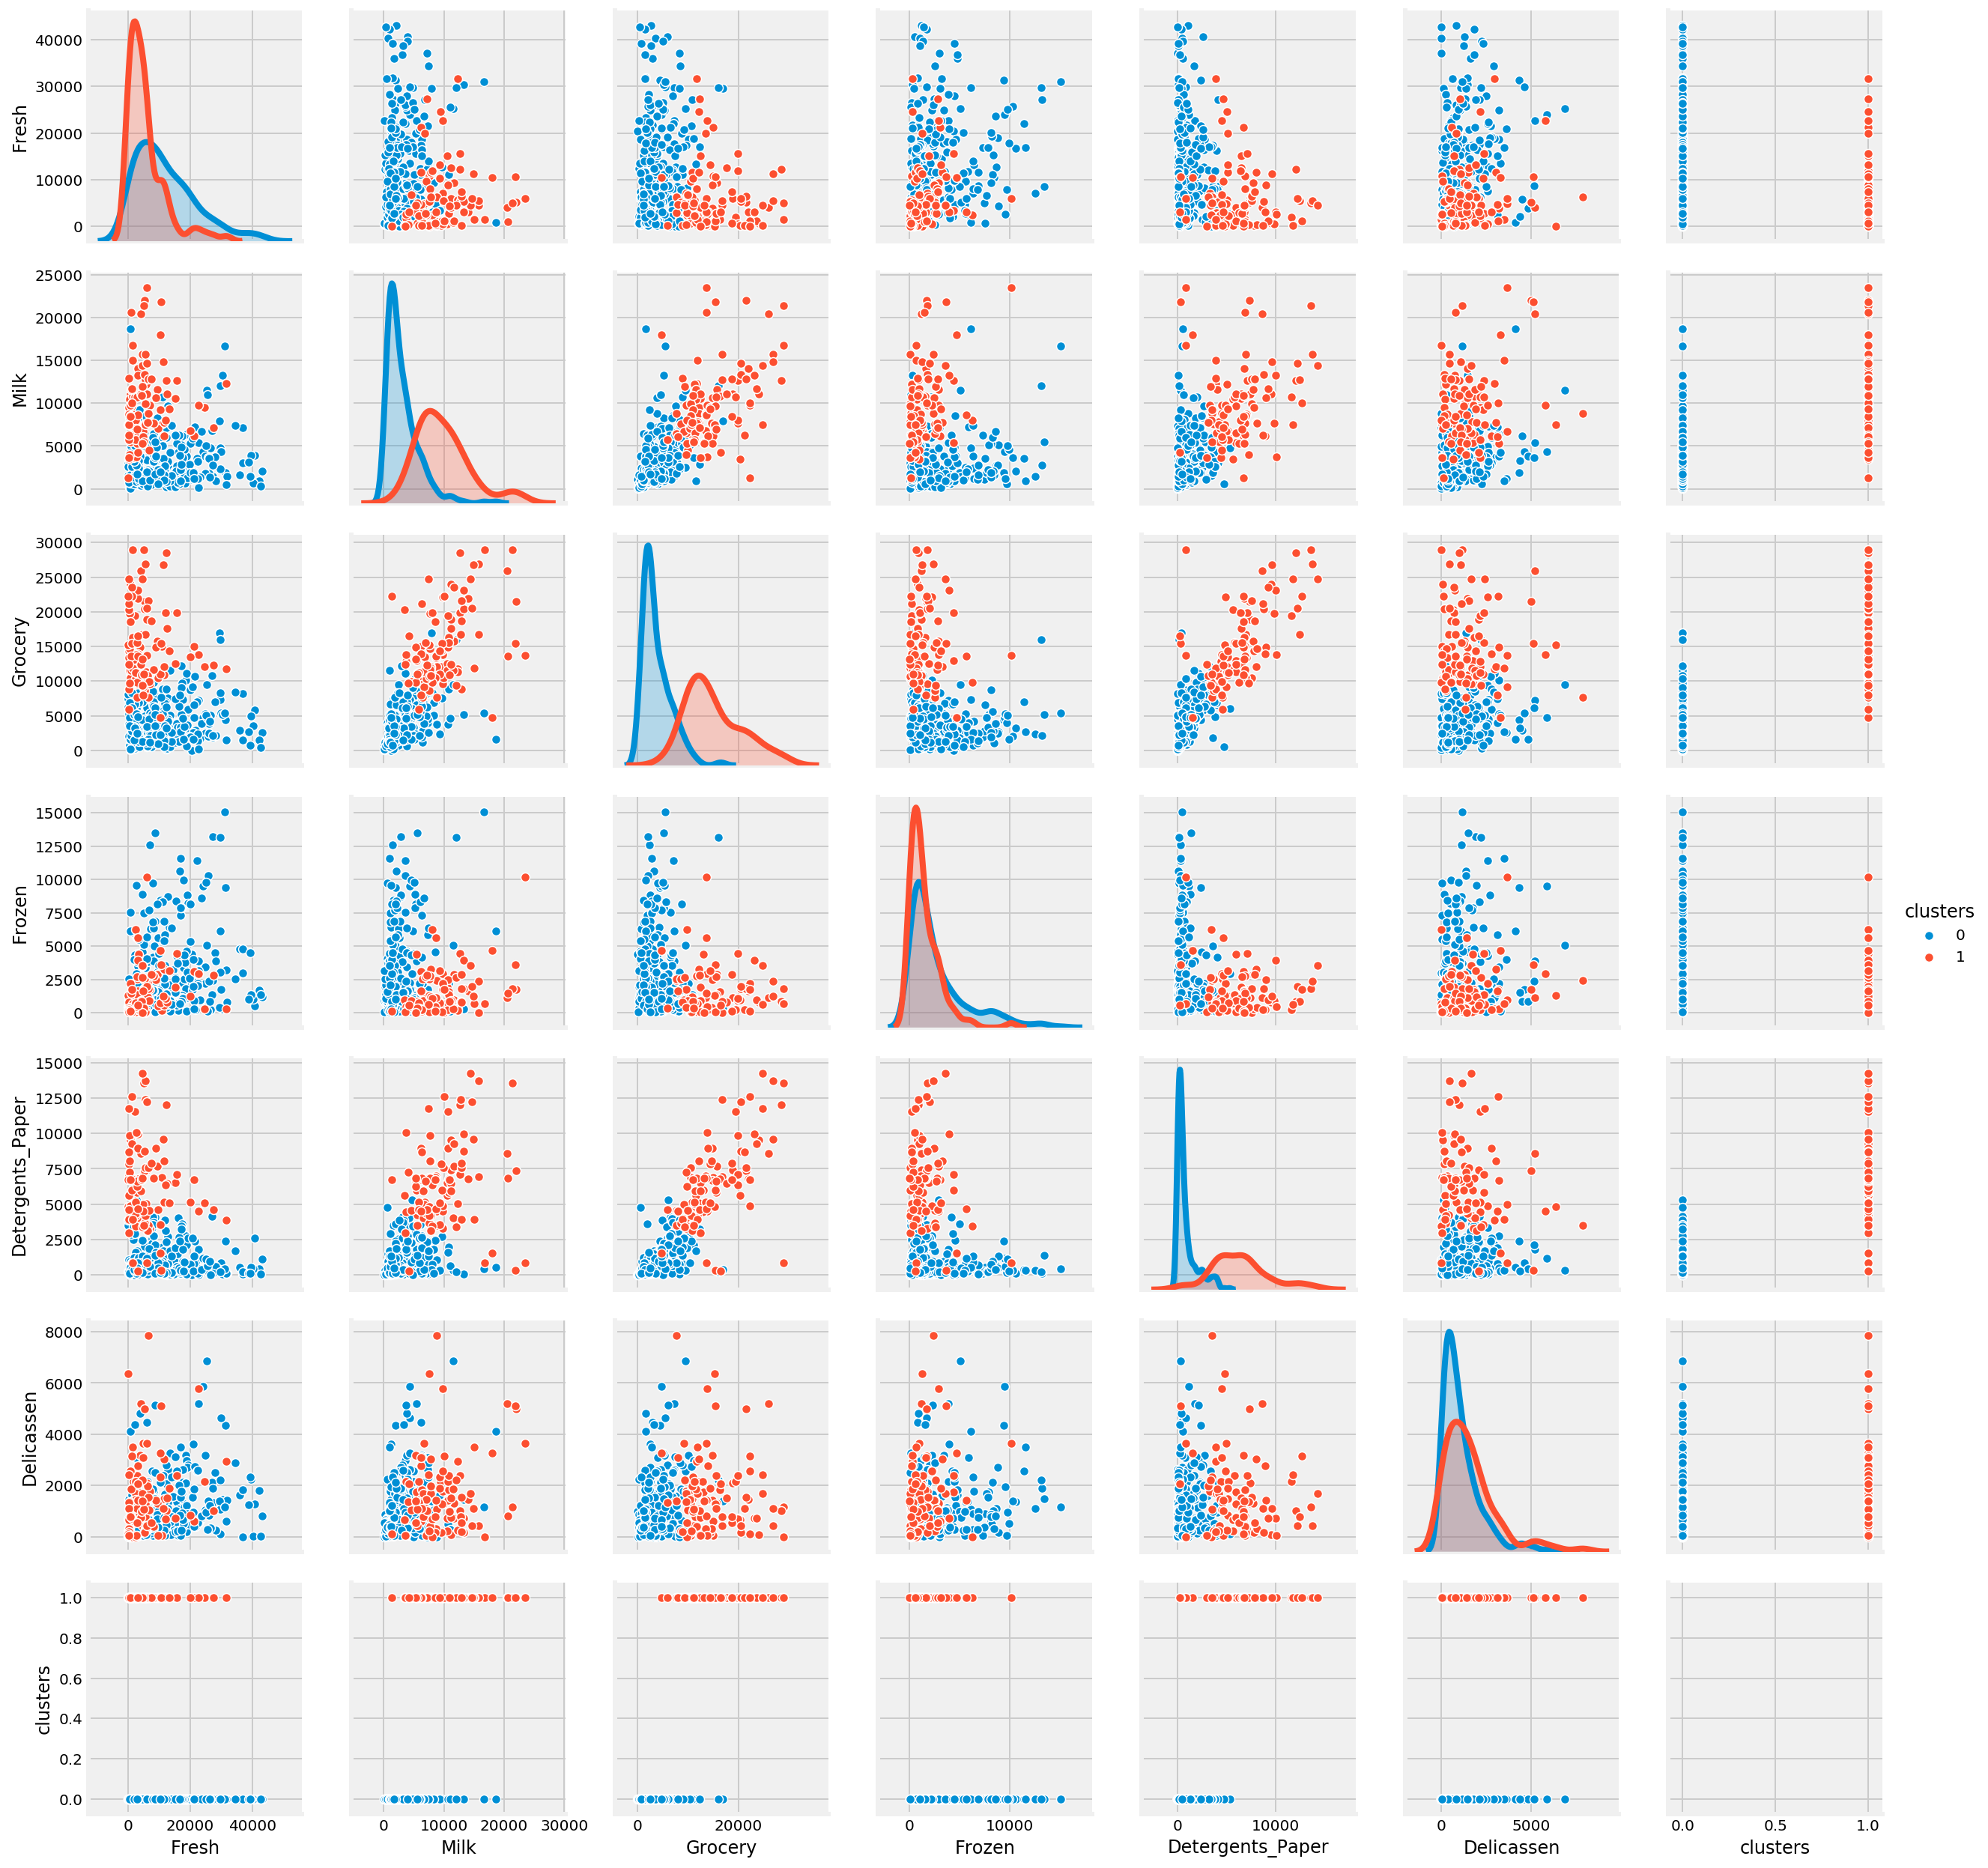

In [29]:
sns.pairplot(X, hue = "clusters")

In [30]:
centers = kmeans.named_steps["kmeans"].cluster_centers_

In [31]:
centers = kmeans.named_steps["kmeans"].cluster_centers_
centers = pd.DataFrame(centers, columns = X.columns[:6])

Text(0.5, 1.0, 'Cluster 0 Center Coordinates')

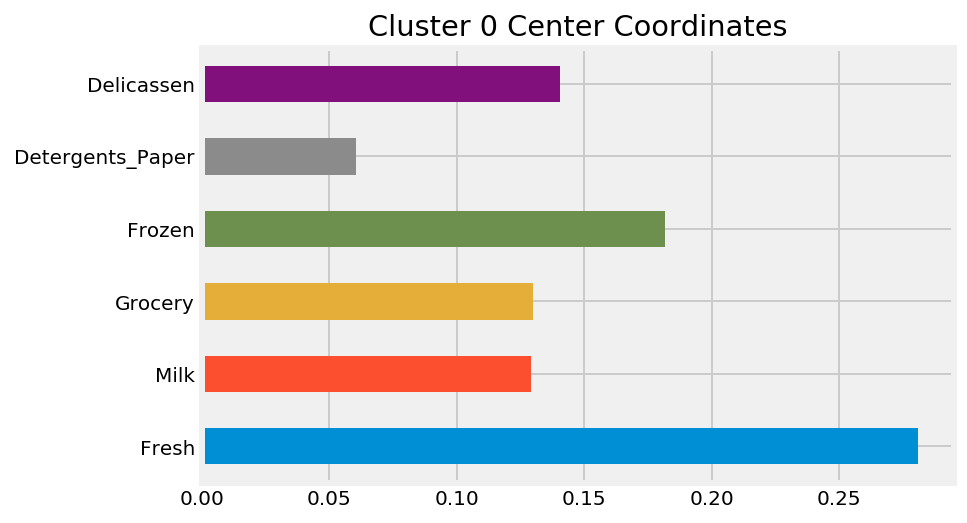

In [32]:
centers.iloc[0].plot(kind = "barh")
plt.title("Cluster 0 Center Coordinates")

Text(0.5, 1.0, 'Cluster 1 Center Coordinates')

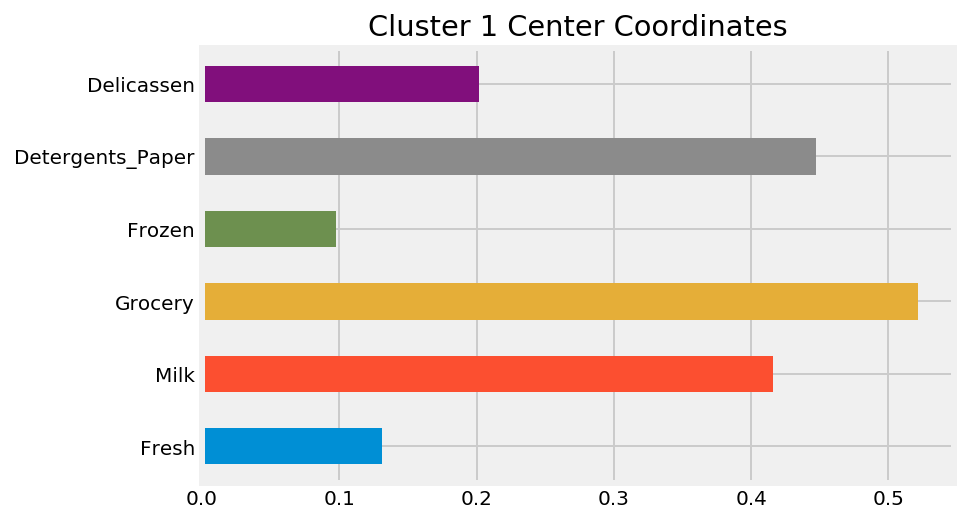

In [33]:
centers.iloc[1].plot(kind = "barh")
plt.title("Cluster 1 Center Coordinates")

We see the separation here:
- **Cluster 1 - Clients who spend a lot in the Detergents, Grocery, and Milk Categories**
- **Cluster 0 - Clients who spend a lot in the Fresh Category and slighlty above average in Frozen**

### Relationship between Segmenting and predifined categories like Channel:
We can see how our clusters compare with other information in the data - for example how are the clusters related to the Channel?

In [34]:
df["cluster"] = X["clusters"]

Text(0.5, 1.0, 'Channel Counts based on Clusters')

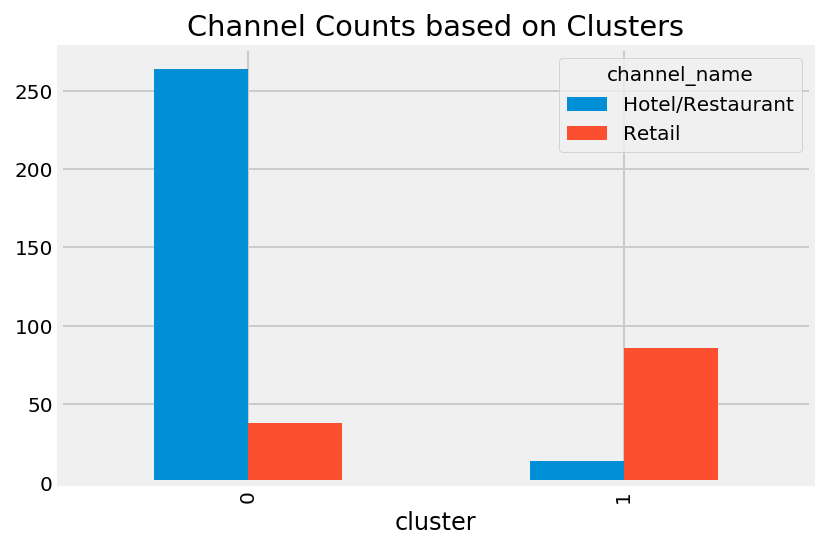

In [35]:
df.groupby(["cluster", "channel_name"])["Frozen"].count().unstack().plot(kind = "bar")
plt.title("Channel Counts based on Clusters")

In [36]:
df.groupby(["cluster", "channel_name"])["Frozen"].count()

cluster  channel_name    
0        Hotel/Restaurant    264
         Retail               38
1        Hotel/Restaurant     14
         Retail               86
Name: Frozen, dtype: int64

We observe the following:

- **Cluster 0 contains 87%  Hotel/Restaurant clients**

- **Cluster 1 has 86% Retail Clients **

**So our customer segmentation has identified and learned the notion of different channels - in this case Hotel\Restaurant vs. Retail:**

- **Cluster 1 is mostly Retail with customers who spend a lot on Detergents, Grocery, and Milk Categories**
- **Cluster 0 is mostly Hotel/Restaurant with clients who spend a lot on the Fresh Category and slighlty above average in Frozen**

The best part is that the clustering algorithm did not have acces to the Channel Labels directly - we only clustered on the spending habits of the clients - the fact that the algorithm managed to segment the clients roughly by channel is remarkable.